# Sumário

[Funções de Ativação](#Funções-de-Ativação)

[Funções Auxiliares](#Funções-Auxiliares)

[Funções de Custo](#Funções-de-Custo)

[Inicialização de Pesos](#Inicialização-de-Pesos)

[Regularização](#Regularização)

[Learning Rate Decay](#Learning-Rate-Decay)

[Batch Normalization](#Batch-Normalization)

[Batch Generator](#Batch-Generator)

[Implementação](#Implementação)

[Testes da Implementação](#Testes-da-Implementação)

- [Exemplos do Notebook da Intuição](#Exemplos-do-Notebook-da-Intuição)

- [Regressão](#Regressão)
    - [Regressão Linear Simples](#Regressão-Linear-Simples---Exemplo-do-Perceptron)
    - [Regressão Linear Multivariada](#Regressão-Linear-Multivariada---Exerc%C3%ADcio-de-Regressão-do-Perceptron)
    - [Regressão Quadrática](#Regressão-Quadrática)
    - [Regressão Cúbica](#Regressão-Cúbica)
    - [Regressão Logarítimica](#Regressão-Logar%C3%ADtimica)
    - [Regressão Exponencial](#Regressão-Exponencial)

- [Classificação Binária](#Classificação-Binária)
    - [Porta AND/OR](#Porta-AND/OR)
    - [Porta XOR](#Porta-XOR)
    - [2 Clusters](#2-Clusters)
    - [4 Clusters](#4-Clusters)
    - [Círculos](#C%C3%ADrculos)
    - [Moons](#Moons)
    - [Espiral](#Espiral)
    
- [Classificação Multiclasse](#Classificação-Multiclasse)
    - [3 Clusters Multiclasse](#3-Clusters-Multiclasse)
    - [4 Clusters Multiclasse](#4-Clusters-Multiclasse)
    - [Espiral - 5 Classes](#Espiral---5-Classes)
    - [Make Classification - 4 Classes](#Make-Classification---4-Classes)
    - [Iris Dataset](#Iris-Dataset)

[Referências](#Referências)

# Imports and Configurações

In [1]:
import numpy as np
import _pickle as pkl
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.datasets.samples_generator import make_blobs, make_circles, make_moons, make_classification
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from utils import plot
from utils.samples_generator import make_spiral, make_square, make_cubic, make_exp, make_log10

%matplotlib inline

/home/anderson/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


# Funções de Ativação

In [2]:
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x

def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y*(1 - y)
    return 1.0/(1.0 + np.exp(-x))

def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

def leaky_relu(x, derivative=False):
    alpha = 0.1
    if derivative:
        return np.where(x <= 0, alpha, 1)
    return np.where(x <= 0, alpha*x, x)

def elu(x, derivative=False):
    alpha = 1.0
    if derivative:
        y = elu(x)
        return np.where(x <= 0, y + alpha, 1)
    return np.where(x <= 0, alpha*(np.exp(x) - 1), x)

# Funções Auxiliares

In [3]:
def softmax(x, y_oh=None, derivative=False):
    if derivative:
        y_pred = softmax(x)
        k = np.nonzero(y_pred * y_oh)
        pk = y_pred[k]
        y_pred[k] = pk * (1.0 - pk)
        return y_pred
    exp = np.exp(x)
    return exp / np.sum(exp, axis=1, keepdims=True)

# Funções de Custo

###### Para Regressão

In [4]:
def mae(y,y_pred,derivative=False):
    if derivative:
        return np.where(y_pred>y,1,-1) / y.shape[0] #o shape é a quantidade de pontos
    return np.mean(np.abs(y-y_pred))

def mse(y,y_pred,derivative=False):
    if derivative:
        return -(y-y_pred)/y.shape[0]
    return 0.5*np.mean((y-y_pred)**2)

###### Para Classificação Binária

In [5]:
def binary_cross_entropy(y,y_pred,derivative=False):
    if derivative:
        return -(y-y_pred)/(y_pred*(1-y_pred)*y.shape[0])
    return -np.mean(y*np.log(y_pred)+(1-y)*np.log(1-y_pred))

def sigmoid_cross_entropy(y,y_pred,derivative=False):
    y_sigmoid = sigmoid(y_pred)
    if derivative:
        -(y-y_sigmoid)/y.shape[0]
    return -np.mean(y*np.log(y_sigmoid)+(1-y)*np.log(1-y_sigmoid))

###### Para Classificação Multiclasse

In [6]:
def neg_log_likelihood(y_oh, y_pred, derivative=False):
    k = np.nonzero(y_pred * y_oh)
    pk = y_pred[k]
    if derivative:
        y_pred[k] = (-1.0 / pk)
        return y_pred
    return np.mean(-np.log(pk))

def softmax_neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_softmax = softmax(y_pred)
    if derivative:
        return -(y_oh - y_softmax) / y_oh.shape[0]    
    return neg_log_likelihood(y_oh, y_softmax)

# Inicialização de Pesos

In [7]:
def zeros(rows, cols):
    return np.zeros((rows,cols))

def ones(rows, cols):
    return np.ones((rows,cols))

def random_normal(rows, cols):
    return np.random.randn(rows, cols)

def random_uniform(rows, cols):
    return np.random.rand(rows, cols)

def glorot_normal(rows, cols):
    std_dev = np.sqrt(2.0 / (rows / cols))
    return std_dev*np.random.randn(rows, cols)

def glorot_uniform(rows, cols):
    limit = np.sqrt(6.0 / (rows + cols))
    return 2*limit*np.random.rand(rows,cols) - limit

# Regularização

In [8]:
def l1_regularization(weights, derivative=False):
    if derivative:
        weights = [np.where(w<0,-1,w) for w in weights]
        return np.array([np.where(w>0,1,w) for w in weights])
    return np.sum([np.sum(np.abs(w)) for w in weights]) #list comprehension

def l2_regularization(weights, derivative=False):
    if derivative:
        return weights
    return 0.5*np.sum(weights**2)

# Batch Generator

In [12]:
def batch_sequential(x,y,batch_size=None):
    batch_size = x.shape[0] if batch_size is None else batch_size
    n_batches = x.shape[0] // batch_size # // significa divisão inteira arredondada para baixo
    
    for batch in range(n_batches):
        offset = batch_size*batch
        x_batch, y_batch = x[offset:offset+batch_size],y[offset:offset+batch_size]
        yield(x_batch,y_batch) #yield é parecido com return mas pausa a função e depois volta onde parou
        
def batch_shuffle(x,y,batch_size=None):
    shuffle_index = np.random.permutation(range(x.shape[0]))
    return batch_sequential(x[shuffle_index],y[shuffle_index],batch_size)
    

# Learning Rate Decay

# Batch Normalization 

# Implementação 

In [13]:
class Layer():
    def __init__(self,input_dim,output_dim, weights_initializer=random_normal,
                 biases_initializer=ones,activation=linear,dropout_prob=0.0,
                reg_func=l2_regularization, reg_strength=0.0): #init é o construtor
        self.input = None
        self.weights = weights_initializer(output_dim,input_dim)
        self.biases = biases_initializer(1,output_dim)
        self.activation = activation
        self.dropout_prob = dropout_prob
        self.reg_func = reg_func
        self.reg_strength = reg_strength
        
        self._activ_inp, self._activ_out = None, None #1 underline para atributos privados
        self._dweights, self._dbiases, self._prev_dweights = None, None, 0.0
        self._dropout_mask = None

class NeuralNetwork():
    def __init__(self,cost_func=mse,learning_rate=1e-3,momentum=0.0):
        self.layers = []
        self.cost_func = cost_func
        self.learning_rate = learning_rate
        self.momentum = momentum
        
    def fit(self, x_train, y_train, epochs=100, verbose=10,batch_gen=batch_sequential,batch_size=None): #método para aprender
        for epoch in range(epochs+1):
            for x_batch,y_batch in batch_gen(x_train,y_train,batch_size):
                y_pred = self.__feedforward(x_batch)
                self.__backprop(y_batch,y_pred)
            
            if epoch%verbose == 0:
                loss_train = self.cost_func(y_train,self.predict(x_train))
                loss_reg = (1.0 / y_train.shape[0])*np.sum([layer.reg_strength*layer.reg_func(layer.weights) for layer in self.layers])
                print("epoch: {0:=4}/{1} loss train: {2:.8f}"
                      .format(epoch,epochs,loss_train))
                
    def predict(self,x): #método para prever
        return self.__feedforward(x,is_training=False)
    
    def __feedforward(self,x,is_training=True): #2 underlines é como um private para função #treinamento
        self.layers[0].input = x
        for current_layer, next_layer in zip(self.layers,self.layers[1:]
                                             +[Layer(0,0)]):#Layer garante mesmo tamanho em ambas
            y = np.dot(current_layer.input,current_layer.weights.T) + current_layer.biases
            current_layer._dropout_mask = np.random.binomial(1,
                                                             1.0-current_layer.dropout_prob,
                                                            y.shape)/(1.0-current_layer.dropout_prob)
            current_layer._activ_inp = y
            current_layer._activ_out = current_layer.activation(y)*(current_layer._dropout_mask if is_training else 1.0)
            next_layer.input = current_layer._activ_out
        return self.layers[-1]._activ_out
        
    def __backprop(self,y,y_pred):
        last_delta = self.cost_func(y, y_pred,derivative=True)
        for layer in reversed(self.layers):
            dactivation = layer.activation(layer._activ_inp,derivative=True)*last_delta*layer._dropout_mask
            last_delta = np.dot(dactivation,layer.weights)
            layer._dweights = np.dot(dactivation.T,layer.input)
            layer._dbiases = 1.0 * dactivation.sum(axis=0,keepdims=True)
        for layer in reversed(self.layers):
            layer._dweights = layer._dweights + (1.0 / y.shape[0])*layer.reg_strength*layer.reg_func(layer.weights,derivative=True)
            layer._prev_dweights = - self.learning_rate * layer._dweights + self.momentum*layer._prev_dweights
            layer.weights = layer.weights + layer._prev_dweights
            layer.biases = layer.biases - self.learning_rate * layer._dbiases

## Exemplos do Notebook da Intuição

### Exemplo 1

In [9]:
x = np.array([[0.05, 0.10]])
y = np.array([[0.01, 0.99]])

w1 = np.array([[0.15, 0.20], [0.25, 0.30]])
b1 = np.array([[0.35]]) 
w2 = np.array([[0.40, 0.45], [0.50, 0.55]])
b2 = np.array([[0.60]])

# insira sua rede aqui!
input_dim, output_dim = x.shape[1],y.shape[1]
nn = NeuralNetwork(cost_func=mse,learning_rate=0.5)
nn.layers.append(Layer(input_dim=input_dim,output_dim=2,activation=sigmoid))#primeira camada
nn.layers.append(Layer(input_dim=2,output_dim=output_dim,activation=sigmoid))

nn.layers[0].weights = w1
nn.layers[0].biases = b1
nn.layers[1].weights = w2
nn.layers[1].biases = b2

nn.fit(x,y,epochs=0,verbose=1)

for layer in nn.layers:
    print(layer.weights)

epoch:    0/0 loss train: 0.14023572
[[0.14978072 0.19956143]
 [0.24975114 0.29950229]]
[[0.35891648 0.40866619]
 [0.51130127 0.56137012]]


### Exemplo 2

In [10]:
x = np.array([[0.1, 0.2, 0.7]])
y = np.array([[1, 0, 0]])
D_in, D_out = x.shape[1], y.shape[1]

w1 = np.array([[0.1, 0.2, 0.3], [0.3, 0.2, 0.7], [0.4, 0.3, 0.9]])
b1 = np.ones((1,3))
w2 = np.array([[0.2, 0.3, 0.5], [0.3, 0.5, 0.7], [0.6, 0.4, 0.8]])
b2 = np.ones((1,3))
w3 = np.array([[0.1, 0.4, 0.8], [0.3, 0.7, 0.2], [0.5, 0.2, 0.9]])
b3 = np.ones((1,3))

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood,learning_rate=0.01)
nn.layers.append(Layer(input_dim=D_in,output_dim=3,activation=relu))
nn.layers.append(Layer(input_dim=3,output_dim=3,activation=sigmoid))
nn.layers.append(Layer(input_dim=3,output_dim=D_out,activation=linear))

for i, w, b in zip(range(3),[w1,w2,w3],[b1,b2,b3]):
    nn.layers[i].weights = w
    nn.layers[i].biases = b

nn.fit(x,y,epochs=300,verbose=30)
for layer in nn.layers:
    print(layer.weights)

epoch:    0/300 loss train: 1.14054966
epoch:   30/300 loss train: 0.59630022
epoch:   60/300 loss train: 0.36031189
epoch:   90/300 loss train: 0.24668884
epoch:  120/300 loss train: 0.18386202
epoch:  150/300 loss train: 0.14510157
epoch:  180/300 loss train: 0.11918285
epoch:  210/300 loss train: 0.10078511
epoch:  240/300 loss train: 0.08712037
epoch:  270/300 loss train: 0.07660623
epoch:  300/300 loss train: 0.06828531
[[0.10083595 0.2016719  0.30585165]
 [0.30086971 0.20173942 0.70608796]
 [0.40145052 0.30290104 0.91015363]]
[[0.20544723 0.30673159 0.50749567]
 [0.30994562 0.5123005  0.71366784]
 [0.61065514 0.41317913 0.81464085]]
[[ 0.66465527  0.98758148  1.39393956]
 [ 0.05020341  0.44006253 -0.06274803]
 [ 0.18514132 -0.12764401  0.56880846]]


## Gradient Checking

## Regressão

### Regressão Linear Simples - Exemplo do Perceptron

(100, 2)
(100, 1) (100, 1)


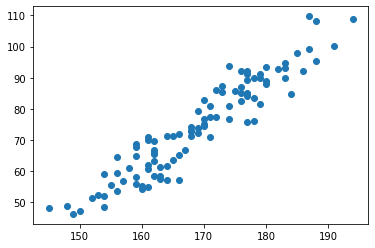

In [11]:
data = np.loadtxt('data/medidas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,0].reshape(-1,1), data[:,1].reshape(-1,1)
print(x.shape, y.shape)
plt.scatter(x, y)

-1.0 0.9999999999999991


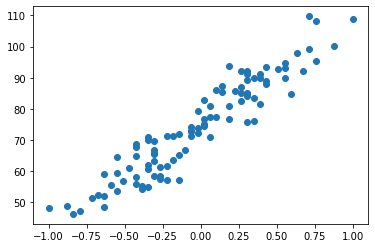

In [12]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(), x.max())
plt.scatter(x, y)

epoch:    0/1000 loss train: 2242.53239220
epoch:  100/1000 loss train: 15.64238250
epoch:  200/1000 loss train: 13.10120514
epoch:  300/1000 loss train: 13.04282976
epoch:  400/1000 loss train: 13.04148877
epoch:  500/1000 loss train: 13.04145797
epoch:  600/1000 loss train: 13.04145726
epoch:  700/1000 loss train: 13.04145724
epoch:  800/1000 loss train: 13.04145724
epoch:  900/1000 loss train: 13.04145724
epoch: 1000/1000 loss train: 13.04145724
[[33.60164744]]
[[74.99636286]]


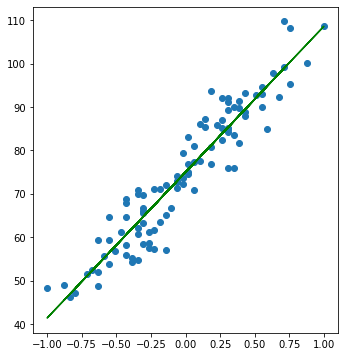

In [16]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=mse,learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim,output_dim=output_dim,activation=linear))
nn.fit(x,y,epochs=1000,verbose=100)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Linear Multivariada - Exercício de Regressão do Perceptron

In [17]:
data = np.loadtxt('data/notas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,:-1], data[:,-1].reshape(-1,1)
print(x.shape, y.shape)

(25, 4)
(25, 3) (25, 1)


In [19]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))
#plt.scatter(x, y)

[-1. -1. -1.] [1. 1. 1.]


In [1]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=mse,learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim,output_dim=output_dim,activation=linear))
nn.fit(x,y,epochs=2000,verbose=200)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

NameError: name 'x' is not defined

### Regressão Quadrática

(100, 1) (100, 1)


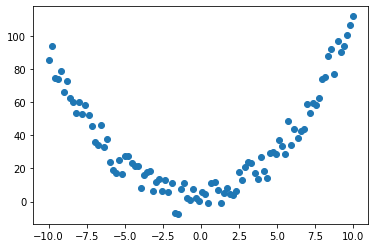

In [19]:
x, y = make_square(n_samples=100, x_min=-10, x_max=10, a=1, b=1, c=1, noise=10)

print(x.shape, y.shape)
plt.scatter(x, y)

In [20]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/5000 loss train: 1013.88713266
epoch:  500/5000 loss train: 24.12665330
epoch: 1000/5000 loss train: 18.55206134
epoch: 1500/5000 loss train: 17.44647070
epoch: 2000/5000 loss train: 16.21474961
epoch: 2500/5000 loss train: 58.74713118
epoch: 3000/5000 loss train: 15.49773554
epoch: 3500/5000 loss train: 15.28788423
epoch: 4000/5000 loss train: 15.09050831
epoch: 4500/5000 loss train: 15.01132050
epoch: 5000/5000 loss train: 14.88424519


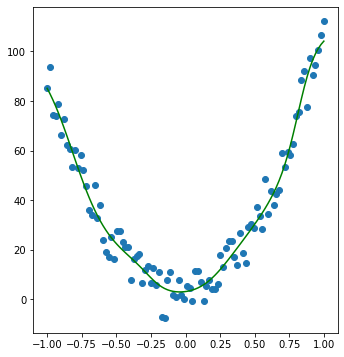

In [22]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=mse,learning_rate=1e-3,momentum=0.9)
nn.layers.append(Layer(input_dim=input_dim,output_dim=10,activation=tanh,
                      weights_initializer=random_uniform))#10 neurônios
nn.layers.append(Layer(input_dim=10,output_dim=10,activation=tanh,
                      weights_initializer=glorot_normal,biases_initializer=random_uniform))
nn.layers.append(Layer(input_dim=10,output_dim=output_dim,activation=linear,
                       weights_initializer=glorot_uniform))

nn.fit(x,y,epochs=5000,verbose=500)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Cúbica

(100, 1) (100, 1)


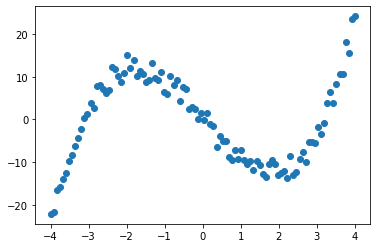

In [23]:
x, y = make_cubic(n_samples=100, x_min=-4, x_max=4, a=1, b=0, c=-10, d=0, noise=3)

print(x.shape, y.shape)
plt.scatter(x, y)

In [24]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/5000 loss train: 52.36480840
epoch:  500/5000 loss train: 48.17629314
epoch: 1000/5000 loss train: 37.15014117
epoch: 1500/5000 loss train: 27.86433845
epoch: 2000/5000 loss train: 21.12420330
epoch: 2500/5000 loss train: 16.29136361
epoch: 3000/5000 loss train: 13.11445763
epoch: 3500/5000 loss train: 10.89056586
epoch: 4000/5000 loss train: 8.78938503
epoch: 4500/5000 loss train: 5.54197977
epoch: 5000/5000 loss train: 3.84070700


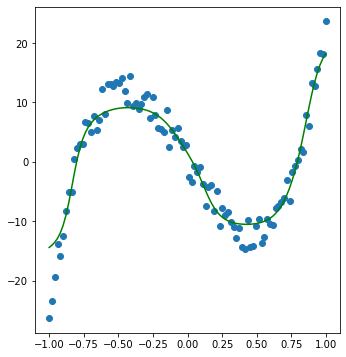

In [28]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=mse,learning_rate=1e-3)
nn.layers.append(Layer(input_dim=input_dim,output_dim=10,activation=tanh))#10 neurônios
nn.layers.append(Layer(input_dim=10,output_dim=10,activation=tanh))
nn.layers.append(Layer(input_dim=10,output_dim=output_dim,activation=linear))

nn.fit(x,y,epochs=5000,verbose=500)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Logarítimica

(100, 1) (100, 1)


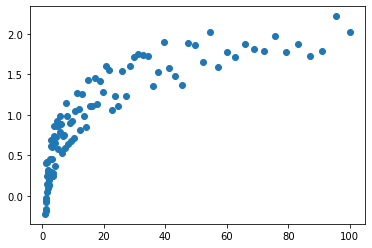

In [29]:
x, y = make_log10(n_samples=100, x_min=1, x_max=100, noise=0.3)

print(x.shape, y.shape)
plt.scatter(x, y)

In [30]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/5000 loss train: 0.18923417
epoch:  500/5000 loss train: 0.02561870
epoch: 1000/5000 loss train: 0.02276719
epoch: 1500/5000 loss train: 0.02150833
epoch: 2000/5000 loss train: 0.02071611
epoch: 2500/5000 loss train: 0.02018297
epoch: 3000/5000 loss train: 0.01981581
epoch: 3500/5000 loss train: 0.01955785
epoch: 4000/5000 loss train: 0.01937112
epoch: 4500/5000 loss train: 0.01923030
epoch: 5000/5000 loss train: 0.01911897


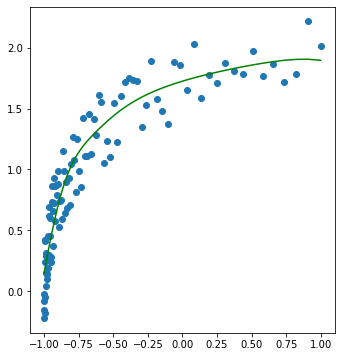

In [32]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=mse,learning_rate=1e-2)
nn.layers.append(Layer(input_dim=input_dim,output_dim=10,activation=tanh))#10 neurônios
nn.layers.append(Layer(input_dim=10,output_dim=10,activation=tanh))
nn.layers.append(Layer(input_dim=10,output_dim=output_dim,activation=linear))

nn.fit(x,y,epochs=5000,verbose=500)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Exponencial

(100, 1) (100, 1)


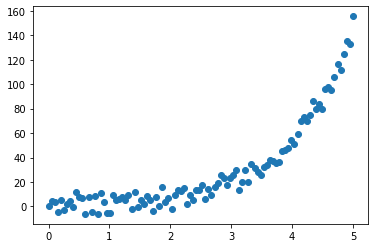

In [33]:
x, y = make_exp(n_samples=100, x_min=0, x_max=5, noise=10)

print(x.shape, y.shape)
plt.scatter(x, y)

In [34]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/5000 loss train: 1169.37775338
epoch:  500/5000 loss train: 172.88092576
epoch: 1000/5000 loss train: 72.14546744
epoch: 1500/5000 loss train: 45.26199503
epoch: 2000/5000 loss train: 33.10592981
epoch: 2500/5000 loss train: 26.49166590
epoch: 3000/5000 loss train: 22.39971641
epoch: 3500/5000 loss train: 19.71135011
epoch: 4000/5000 loss train: 17.89215367
epoch: 4500/5000 loss train: 16.63707185
epoch: 5000/5000 loss train: 15.75354127


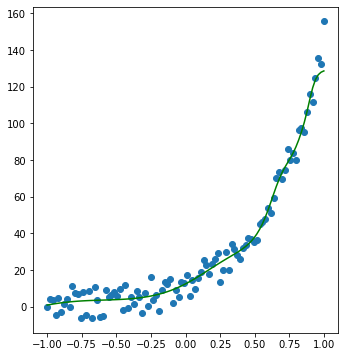

In [35]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=mse,learning_rate=1e-3)
nn.layers.append(Layer(input_dim=input_dim,output_dim=10,activation=tanh))#10 neurônios
nn.layers.append(Layer(input_dim=10,output_dim=10,activation=tanh))
nn.layers.append(Layer(input_dim=10,output_dim=output_dim,activation=linear))

nn.fit(x,y,epochs=5000,verbose=500)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

## Classificação Binária

### Porta AND/OR

(4, 2) (4, 1)


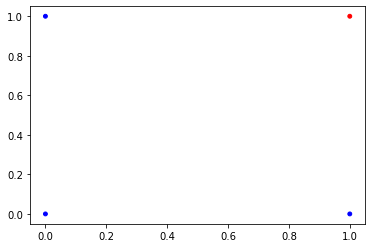

In [48]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 0, 0, 1]).reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/1000 loss train: 0.51167493
epoch:  100/1000 loss train: 0.13203263
epoch:  200/1000 loss train: 0.07760145
epoch:  300/1000 loss train: 0.05450982
epoch:  400/1000 loss train: 0.04184442
epoch:  500/1000 loss train: 0.03388428
epoch:  600/1000 loss train: 0.02843404
epoch:  700/1000 loss train: 0.02447545
epoch:  800/1000 loss train: 0.02147341
epoch:  900/1000 loss train: 0.01912051
epoch: 1000/1000 loss train: 0.01722785
Predições:
[[1.20463992e-05]
 [2.00236265e-02]
 [2.00236003e-02]
 [9.71955030e-01]]
Acurácia: 100.00%


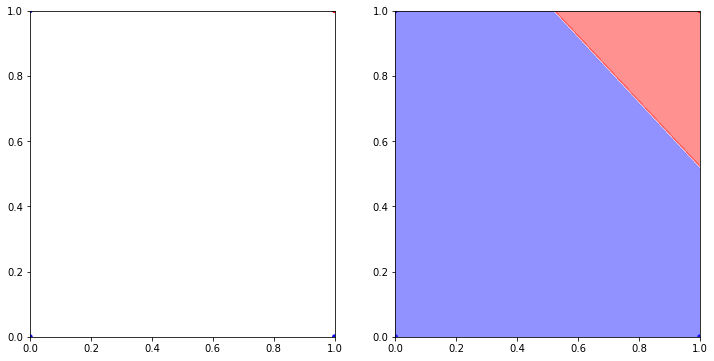

In [50]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=binary_cross_entropy,learning_rate=1.0)
nn.layers.append(Layer(input_dim=input_dim,output_dim=output_dim,activation=sigmoid))

nn.fit(x,y,epochs=1000,verbose=100)

y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Porta XOR

(4, 2) (4, 1)


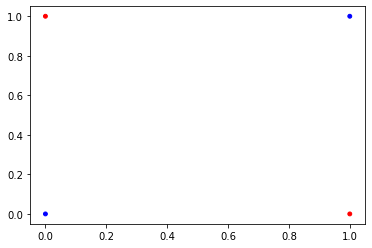

In [38]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0]).reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/1000 loss train: 0.73892243
epoch:  100/1000 loss train: 0.69078288
epoch:  200/1000 loss train: 0.66120742
epoch:  300/1000 loss train: 0.49486847
epoch:  400/1000 loss train: 0.15369404
epoch:  500/1000 loss train: 0.06744274
epoch:  600/1000 loss train: 0.04143732
epoch:  700/1000 loss train: 0.02953649
epoch:  800/1000 loss train: 0.02282260
epoch:  900/1000 loss train: 0.01854272
epoch: 1000/1000 loss train: 0.01558811
Predições:
[[0.01820464]
 [0.98635404]
 [0.98568633]
 [0.0156985 ]]
Acurácia: 100.00%


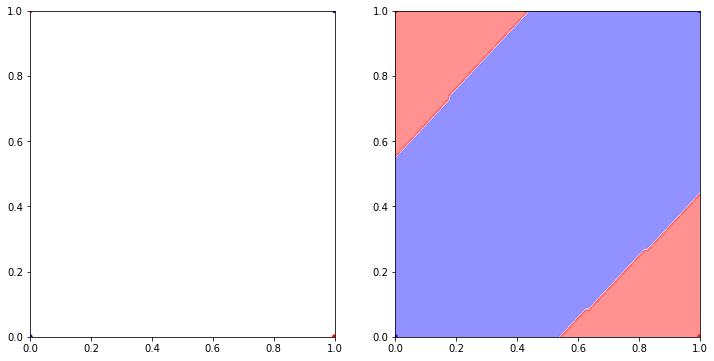

In [41]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=binary_cross_entropy,learning_rate=1.0)
nn.layers.append(Layer(input_dim=input_dim,output_dim=2,activation=sigmoid))
nn.layers.append(Layer(input_dim=2,output_dim=output_dim,activation=sigmoid))

nn.fit(x,y,epochs=1000,verbose=100)


y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### 2 Clusters

(100, 2) (100, 1)


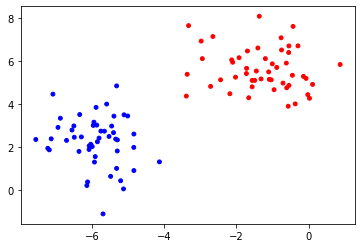

In [45]:
x, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/5000 loss train: 0.35906767
epoch:  500/5000 loss train: 0.00880294
epoch: 1000/5000 loss train: 0.00583712
epoch: 1500/5000 loss train: 0.00461278
epoch: 2000/5000 loss train: 0.00390802
epoch: 2500/5000 loss train: 0.00343690
epoch: 3000/5000 loss train: 0.00309373
epoch: 3500/5000 loss train: 0.00282943
epoch: 4000/5000 loss train: 0.00261774
epoch: 4500/5000 loss train: 0.00244320
epoch: 5000/5000 loss train: 0.00229606
Acurácia: 100.00%


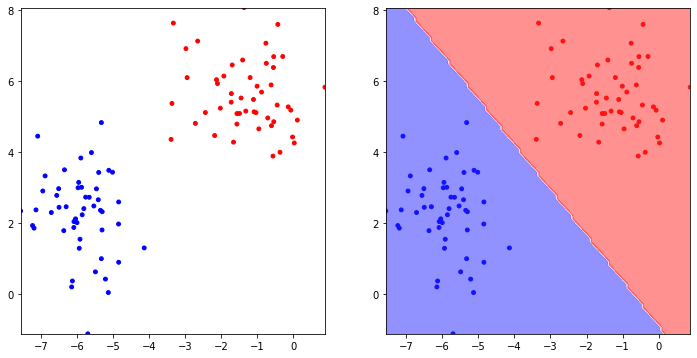

In [46]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=binary_cross_entropy,learning_rate=0.1)
nn.layers.append(Layer(input_dim=input_dim,output_dim=output_dim,activation=sigmoid))

nn.fit(x,y,epochs=5000,verbose=500) 

y_pred = nn.predict(x)

threshold = 0 if nn.layers[-1].activation == linear else 0.5
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred >= threshold)))
plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=threshold, cmap='bwr')

### 4 Clusters

(500, 2) (500, 1)


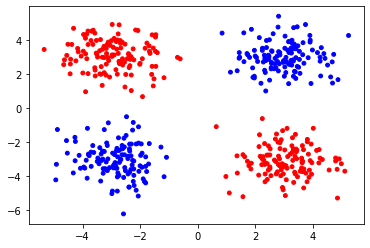

In [51]:
x, y = make_blobs(n_samples=500, n_features=2, cluster_std=0.9, centers=[(-3, -3), (3, 3), (-3, 3), (3, -3)], random_state=1234)
y = y.reshape(-1, 1)
y = np.where(y >= 2, 1, 0)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/5000 loss train: 0.72468996
epoch:  500/5000 loss train: 0.47270424
epoch: 1000/5000 loss train: 0.21410419
epoch: 1500/5000 loss train: 0.12979394
epoch: 2000/5000 loss train: 0.09399723
epoch: 2500/5000 loss train: 0.07463185
epoch: 3000/5000 loss train: 0.06256021
epoch: 3500/5000 loss train: 0.05433050
epoch: 4000/5000 loss train: 0.04836710
epoch: 4500/5000 loss train: 0.04385059
epoch: 5000/5000 loss train: 0.04031317
Acurácia: 99.40%


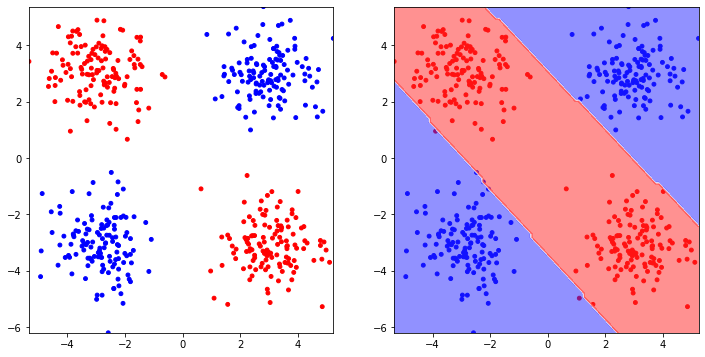

In [52]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=binary_cross_entropy,learning_rate=0.1)
nn.layers.append(Layer(input_dim=input_dim,output_dim=2,activation=sigmoid))
nn.layers.append(Layer(input_dim=2,output_dim=output_dim,activation=sigmoid))

nn.fit(x,y,epochs=5000,verbose=500) 

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Círculos

(500, 2) (500, 1)


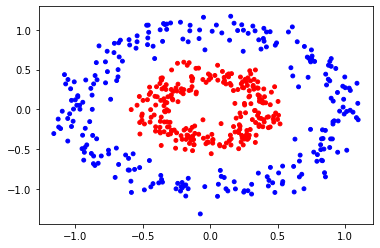

In [53]:
x, y = make_circles(n_samples=500, noise=0.1, factor=0.4, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/1000 loss train: 3.78405096
epoch:  100/1000 loss train: 0.10050430
epoch:  200/1000 loss train: 0.04728966
epoch:  300/1000 loss train: 0.03078579
epoch:  400/1000 loss train: 0.02222571
epoch:  500/1000 loss train: 0.01748266
epoch:  600/1000 loss train: 0.01433642
epoch:  700/1000 loss train: 0.01212182
epoch:  800/1000 loss train: 0.01047868
epoch:  900/1000 loss train: 0.00920223
epoch: 1000/1000 loss train: 0.00817520
Acurácia: 100.00%


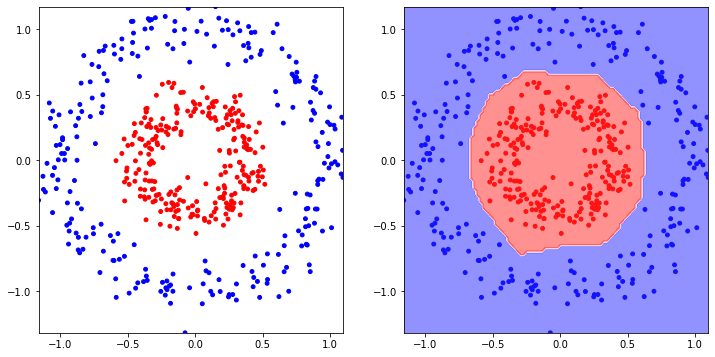

In [54]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=binary_cross_entropy,learning_rate=0.1)
nn.layers.append(Layer(input_dim=input_dim,output_dim=8,activation=relu))
nn.layers.append(Layer(input_dim=8,output_dim=8,activation=relu))
nn.layers.append(Layer(input_dim=8,output_dim=output_dim,activation=sigmoid))

nn.fit(x,y,epochs=1000,verbose=100) 

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Moons

(200, 2) (200, 1)


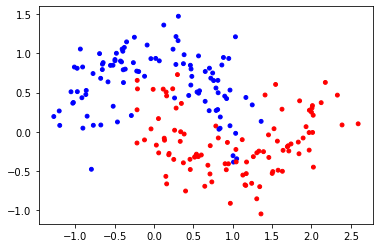

In [11]:
x, y = make_moons(200, noise=0.20)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/2000 loss train: 1.11004012
epoch:  200/2000 loss train: 0.32883230
epoch:  400/2000 loss train: 0.31933503
epoch:  600/2000 loss train: 0.31145889
epoch:  800/2000 loss train: 0.30313867
epoch: 1000/2000 loss train: 0.29356564
epoch: 1200/2000 loss train: 0.28249582
epoch: 1400/2000 loss train: 0.26978130
epoch: 1600/2000 loss train: 0.25314065
epoch: 1800/2000 loss train: 0.22659733
epoch: 2000/2000 loss train: 0.19980939
Acurácia: 92.00%


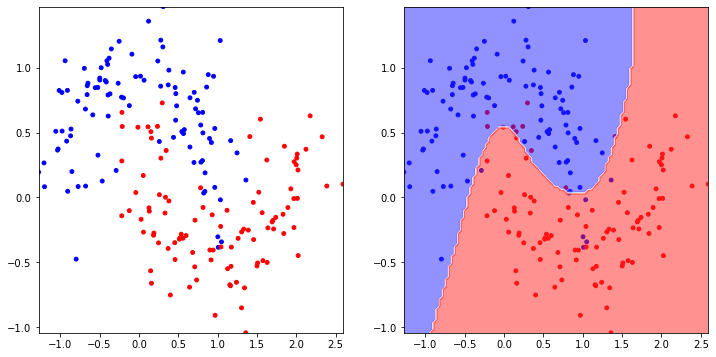

In [17]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=binary_cross_entropy,learning_rate=0.1)
nn.layers.append(Layer(input_dim=input_dim,output_dim=8,activation=tanh, reg_strength=0.1, reg_func=l2_regularization))#8 neurônios
nn.layers.append(Layer(input_dim=8,output_dim=output_dim,activation=sigmoid, reg_strength=0.1, reg_func=l2_regularization))
nn.fit(x,y,epochs=2000,verbose=200)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Espiral

(200, 2) (200, 1)


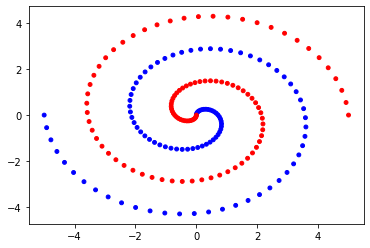

In [57]:
x, y = make_spiral(n_samples=100, n_class=2, radius=5, laps=1.75)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/2000 loss train: 0.85644711
epoch:  200/2000 loss train: 0.57030466
epoch:  400/2000 loss train: 0.50394210
epoch:  600/2000 loss train: 0.42641467
epoch:  800/2000 loss train: 0.32052443
epoch: 1000/2000 loss train: 0.23164136
epoch: 1200/2000 loss train: 0.16747144
epoch: 1400/2000 loss train: 0.12345247
epoch: 1600/2000 loss train: 0.09644903
epoch: 1800/2000 loss train: 0.07888640
epoch: 2000/2000 loss train: 0.06636173
Acurácia: 99.00%


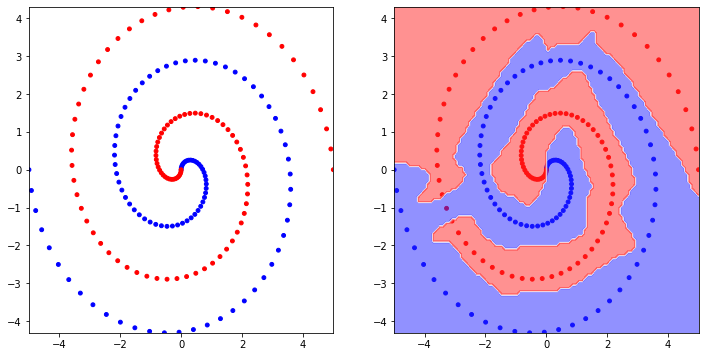

In [60]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=binary_cross_entropy,learning_rate=0.1)
nn.layers.append(Layer(input_dim=input_dim,output_dim=8,activation=tanh))#8 neurônios
nn.layers.append(Layer(input_dim=8,output_dim=8,activation=tanh))#8 neurônios
nn.layers.append(Layer(input_dim=8,output_dim=8,activation=tanh))#8 neurônios
nn.layers.append(Layer(input_dim=8,output_dim=output_dim,activation=sigmoid))
nn.fit(x,y,epochs=2000,verbose=200)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

## Classificação Multiclasse

### 3 Clusters Multiclasse

(300, 2) (300, 1)


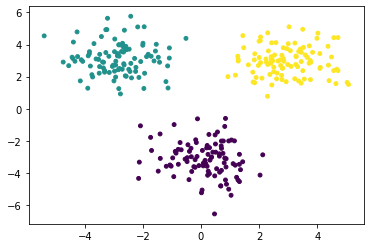

In [61]:
x, y = make_blobs(n_samples=300, n_features=2, centers=[(0, -3), (-3, 3), (3, 3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [69]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::60])

[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


epoch:    0/2000 loss train: 2.96334863
epoch:  200/2000 loss train: 0.05342440
epoch:  400/2000 loss train: 0.02485289
epoch:  600/2000 loss train: 0.01608600
epoch:  800/2000 loss train: 0.01186196
epoch: 1000/2000 loss train: 0.00938449
epoch: 1200/2000 loss train: 0.00776088
epoch: 1400/2000 loss train: 0.00661201
epoch: 1600/2000 loss train: 0.00575586
epoch: 1800/2000 loss train: 0.00509381
epoch: 2000/2000 loss train: 0.00456666
Acurácia: 100.00%


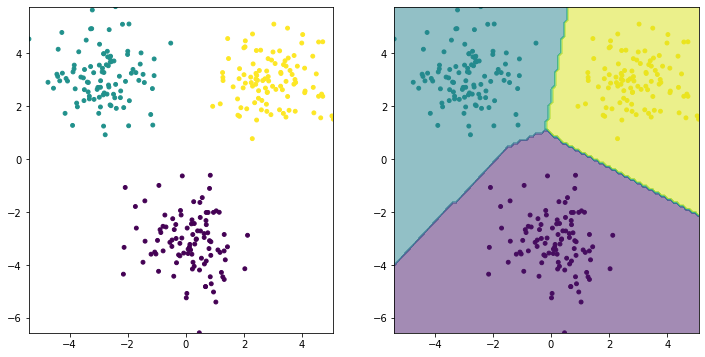

In [70]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood,learning_rate=0.1)
nn.layers.append(Layer(input_dim=input_dim,output_dim=2,activation=relu))
nn.layers.append(Layer(input_dim=2,output_dim=output_dim,activation=linear))
nn.fit(x,y_onehot,epochs=2000,verbose=200)
    
y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### 4 Clusters Multiclasse

(400, 2) (400, 1)


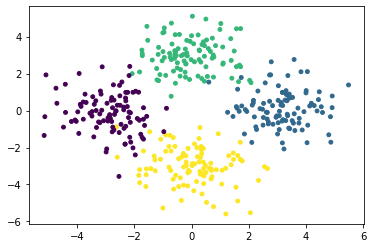

In [71]:
x, y = make_blobs(n_samples=400, n_features=2, centers=[(-3, 0), (3, 0), (0, 3), (0, -3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [72]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::70])

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


epoch:    0/2000 loss train: 2.23970806
epoch:  200/2000 loss train: 0.14197039
epoch:  400/2000 loss train: 0.10402877
epoch:  600/2000 loss train: 0.09389916
epoch:  800/2000 loss train: 0.08906653
epoch: 1000/2000 loss train: 0.08601130
epoch: 1200/2000 loss train: 0.08375522
epoch: 1400/2000 loss train: 0.08193589
epoch: 1600/2000 loss train: 0.08037930
epoch: 1800/2000 loss train: 0.07900353
epoch: 2000/2000 loss train: 0.07776308
Acurácia: 97.25%


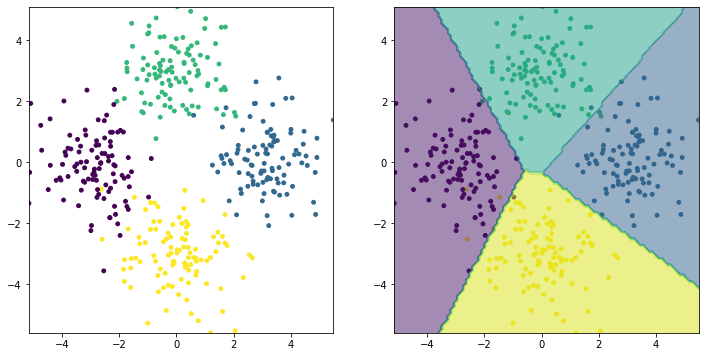

In [74]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood,learning_rate=0.1)
nn.layers.append(Layer(input_dim=input_dim,output_dim=3,activation=relu))
nn.layers.append(Layer(input_dim=3,output_dim=output_dim,activation=linear))
nn.fit(x,y_onehot,epochs=2000,verbose=200)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Espiral - 5 Classes

(500, 2) (500, 1)


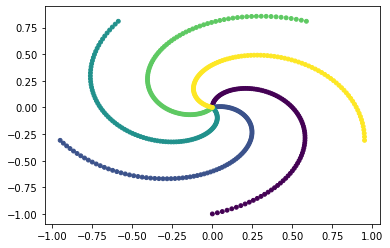

In [75]:
x, y = make_spiral(n_samples=100, n_class=5, radius=1, laps=0.5)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [76]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::100])

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


epoch:    0/2000 loss train: 2.87060802
epoch:  200/2000 loss train: 0.62223155
epoch:  400/2000 loss train: 0.38364954
epoch:  600/2000 loss train: 0.27161671
epoch:  800/2000 loss train: 0.21004463
epoch: 1000/2000 loss train: 0.17186177
epoch: 1200/2000 loss train: 0.14633423
epoch: 1400/2000 loss train: 0.12845887
epoch: 1600/2000 loss train: 0.11510624
epoch: 1800/2000 loss train: 0.10484736
epoch: 2000/2000 loss train: 0.09676371
Acurácia: 97.80%


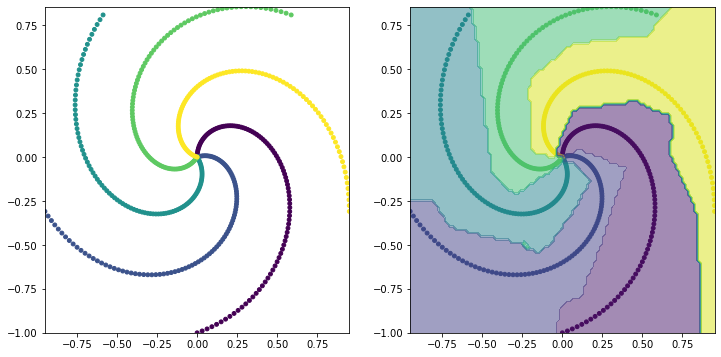

In [82]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood,learning_rate=0.1)
nn.layers.append(Layer(input_dim=input_dim,output_dim=10,activation=relu))
nn.layers.append(Layer(input_dim=10,output_dim=10,activation=relu))
nn.layers.append(Layer(input_dim=10,output_dim=output_dim,activation=linear))
nn.fit(x,y_onehot,epochs=2000,verbose=200)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Make Classification - 4 Classes

(100, 2) (100, 1)


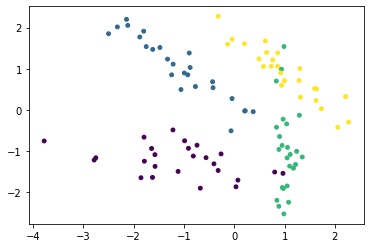

In [83]:
x, y = make_classification(n_samples=100, n_classes=4, n_features=2, n_clusters_per_class=1, n_redundant=0, n_repeated=0, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [84]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::10])

[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


epoch:    0/2000 loss train: 4.27931730
epoch:  100/2000 loss train: 0.33772706
epoch:  200/2000 loss train: 0.28862767
epoch:  300/2000 loss train: 0.27111939
epoch:  400/2000 loss train: 0.25975938
epoch:  500/2000 loss train: 0.25130922
epoch:  600/2000 loss train: 0.24451861
epoch:  700/2000 loss train: 0.23872859
epoch:  800/2000 loss train: 0.23382671
epoch:  900/2000 loss train: 0.22941940
epoch: 1000/2000 loss train: 0.22547933
epoch: 1100/2000 loss train: 0.22182793
epoch: 1200/2000 loss train: 0.21830682
epoch: 1300/2000 loss train: 0.21534742
epoch: 1400/2000 loss train: 0.21268294
epoch: 1500/2000 loss train: 0.21024169
epoch: 1600/2000 loss train: 0.20800289
epoch: 1700/2000 loss train: 0.20594433
epoch: 1800/2000 loss train: 0.20404205
epoch: 1900/2000 loss train: 0.20227448
epoch: 2000/2000 loss train: 0.20062709
Acurácia: 93.00%


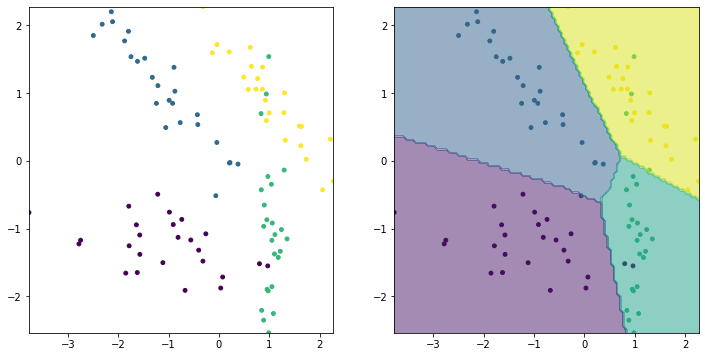

In [89]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood,learning_rate=0.1)
nn.layers.append(Layer(input_dim=input_dim,output_dim=5,activation=relu))
nn.layers.append(Layer(input_dim=5,output_dim=output_dim,activation=linear))
nn.fit(x,y_onehot,epochs=2000,verbose=100)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Iris Dataset

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
(150, 2) (150, 1)


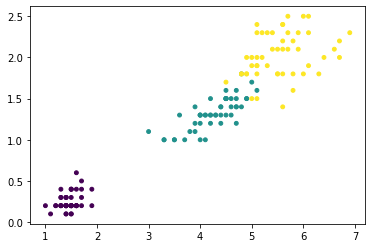

In [14]:
data = load_iris()
x, y = data.data[:, 2:], data.target.reshape(-1,1)

print(data.feature_names)
print(data.target_names)
print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [15]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::20])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


epoch:    0/2000 loss train: 0.95986907
epoch:  200/2000 loss train: 0.39362659
epoch:  400/2000 loss train: 0.55725732
epoch:  600/2000 loss train: 0.14922764
epoch:  800/2000 loss train: 0.12662261
epoch: 1000/2000 loss train: 0.08689203
epoch: 1200/2000 loss train: 0.07831342
epoch: 1400/2000 loss train: 0.10106751
epoch: 1600/2000 loss train: 0.11682225
epoch: 1800/2000 loss train: 0.09425061
epoch: 2000/2000 loss train: 0.07691947
Acurácia: 96.00%


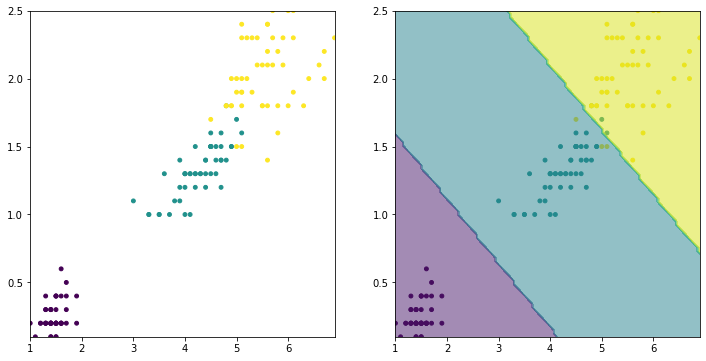

In [16]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood,learning_rate=0.1)
nn.layers.append(Layer(input_dim=input_dim,output_dim=3,activation=relu))
nn.layers.append(Layer(input_dim=3,output_dim=output_dim,activation=linear))
nn.fit(x,y_onehot,epochs=2000,verbose=200,batch_gen=batch_shuffle,batch_size=15)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

# [Link para o Questionário](https://docs.google.com/forms/d/e/1FAIpQLSf1B3JKsPPPc1oYD_3FyX4UvNLpcXnTW2I177A_WE0_B56Elw/viewform?usp=sf_link)

# Referências

- [Tensorflow Playground](http://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.94880&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

- [Linear Classification](http://cs231n.github.io/linear-classify/)

__Regularization__:
- [Implementing Neural Network L1 Regularization](https://jamesmccaffrey.wordpress.com/2017/06/27/implementing-neural-network-l1-regularization/)
- [Implementing Neural Network L2 Regularization](https://jamesmccaffrey.wordpress.com/2017/06/29/implementing-neural-network-l2-regularization/)
- [Neural Network L2 Regularization Using Python](https://visualstudiomagazine.com/articles/2017/09/01/neural-network-l2.aspx)

__Momentum__:
- [Neural Network Momentum Using Python](https://visualstudiomagazine.com/articles/2017/08/01/neural-network-momentum.aspx)
- [Beyond SGD: Gradient Descent with Momentum and Adaptive Learning Rate](https://wiseodd.github.io/techblog/2016/06/22/nn-optimization/)

__Learning Rate Decay__:
- [Using Learning Rate Schedules for Deep Learning Models in Python with Keras](https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/)
- [Learning Rate Schedules and Adaptive Learning Rate Methods for Deep Learning](https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1)
- [Tensorflow Exponential Decay Documentation](https://www.tensorflow.org/api_docs/python/tf/train/exponential_decay)

__Batch Normalization__:
- [Understanding the backward pass through Batch Normalization Layer](https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html)
- [Deriving the Gradient for the Backward Pass of Batch Normalization](https://kevinzakka.github.io/2016/09/14/batch_normalization/)
- [Implementing BatchNorm in Neural Net](https://wiseodd.github.io/techblog/2016/07/04/batchnorm/)
- [What does the gradient flowing through batch normalization looks like ?](http://cthorey.github.io./backpropagation/)
- [GRADIENTS, BATCH NORMALIZATION AND LAYER NORMALIZATION](https://theneuralperspective.com/2016/10/27/gradient-topics/)

__Gradient Checking__:
- [cs231n](https://github.com/cs231n/cs231n.github.io/blob/master/neural-networks-3.md#gradcheck)
- [Gradient checking and advanced optimization](http://ufldl.stanford.edu/wiki/index.php/Gradient_checking_and_advanced_optimization)
- [BatchNormalization fails gradient checking](https://github.com/torch/nn/issues/744)